# Определение перспективного мобильного тарифа из 2х вариантов, чтобы выбрать куда вкладывать маркетинговый бюджет больше на основе звонков, интернета, сообщений и данных о самих пользвотелях и самих тарифах

In [48]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import factorial
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')


In [3]:
calls.sample()

,id,call_date,duration,user_id
12418,1032_437,2018-09-14,5.06,1032


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.isnull().sum() #нет пропусков, с типами данных тоже все хорошо

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [6]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [7]:
internet.info() #п

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [8]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [9]:
internet.sample().isnull().sum() #аналогично

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [10]:
messages.sample().isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [12]:
tariffs.sample()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [14]:
users.isnull().sum() #знаем из описания, что 462 еще пользуются тарифом

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


# Шаг 2

# Шаг 2.1

Округляем длитеьность разговора в большую сторону и приводим к единому формату для формирования общей таблица о пользователях. А так же добавляем месяц и год

In [17]:
def m_ceil(m_cel):# Данная функция нужна для округления в большую сторону
    return int(math.ceil(m_cel))

calls['duration'] = calls['duration'].replace(0, 1)
#Согласно правилам тарифа округляем длительность разговора до минут в большую сторону.
calls['duration'] = calls['duration'].apply(m_ceil)
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')#Z%H:%M:%S')
calls['date'] = calls['call_date']
calls['year'] = pd.DatetimeIndex(calls['call_date']).year
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.drop(['call_date'], axis='columns', inplace=True)
calls.sample(3)

,id,duration,user_id,date,year,month
156858,1388_18,7,1388,2018-11-08,2018,11
199412,1491_371,6,1491,2018-05-25,2018,5
92843,1233_188,1,1233,2018-11-29,2018,11


Аналогично проделываем с интернетом

In [18]:
internet['mb_used'] = internet['mb_used'].replace(0, 1)
#Согласно правилам тарифа округляем трайик до мегабайт в большую сторону.
internet['mb_used'] = internet['mb_used'].apply(m_ceil)
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')#Z%H:%M:%S')
internet['year'] = pd.DatetimeIndex(internet['session_date']).year
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet['date'] = internet['session_date']
internet.drop(['session_date'], axis='columns', inplace=True)
internet.sample()

,id,mb_used,user_id,year,month,date
145181,1484_62,31,1484,2018,10,2018-10-20


Обрабатываем формат даты для сообщения и пользователей

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')#Z%H:%M:%S')
messages['year'] = pd.DatetimeIndex(messages['message_date']).year
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages['date'] = messages['message_date']
messages.drop(['message_date'], axis='columns', inplace=True)
messages.sample()


,id,user_id,year,month,date
53333,1235_211,1235,2018,10,2018-10-06


In [21]:
users['reg_date'] = users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')#Z%H:%M:%S')
users['year'] = pd.DatetimeIndex(users['reg_date']).year
users['month'] = pd.DatetimeIndex(users['reg_date']).month
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')#Z%H:%M:%S')
users['date'] = users['reg_date']
users.sample()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,year,month,date
102,1102,28,NaT,Москва,Марта,Королькова,2018-06-16,smart,2018,6,2018-06-16


Переименоваем series тарифов

In [24]:
tariffs.set_axis(['messages_included'
                  , 'mg_per_month_included'
                  , 'minutes_included'
                  , 'rub_monthly_fee'
                  , 'rub_per_gb'
                  , 'rub_per_message'
                  , 'rub_per_minute'
                  , 'tariff'],axis ='columns',inplace = True)
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


# Шаг 2.2

Подготовим данные для формирования статистики по использованию тарифа.

In [26]:
#Подготовим данные для формирования статистики по использованию тарифа.
calls_duration = calls.pivot_table(index = ['user_id' ,'year', 'month'], values = 'duration', aggfunc = 'sum').reset_index()
calls_duration.set_axis(['user_id' ,'year', 'month', 'tallk_time'], axis ='columns', inplace = True)
#calls_duration.sample()
calls_cnt = calls.pivot_table(index = ['user_id', 'year', 'month'], values = 'duration', aggfunc = 'count').reset_index()
calls_cnt.set_axis(['user_id' ,'year', 'month', 'calls'], axis ='columns', inplace = True)
#calls_cnt.sample()
internet_info =  internet.pivot_table(index = ['user_id' ,'year', 'month'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_info.set_axis(['user_id' ,'year', 'month', 'mb_used'], axis ='columns', inplace = True)
#internet_info.sample()
mess_send = messages.pivot_table(index = ['user_id' ,'year', 'month'], values = 'date', aggfunc = 'count').reset_index()
mess_send.set_axis(['user_id' ,'year', 'month', 'messages'], axis ='columns', inplace = True)
#mess_send.sample()

Объединяем и получаем общую информацию о пользователях

In [27]:
info_table = pd.merge(
    calls_duration
    , pd.merge(calls_cnt 
        , pd.merge(internet_info
            , mess_send
            , on = ['user_id', 'year', 'month']
            , how='outer')
        , on = ['user_id', 'year', 'month']
        , how='outer')
    , on = ['user_id', 'year', 'month']
    , how='outer')
info_table['user_id'] = info_table['user_id'].astype('int')
info_table.sample()

,user_id,year,month,tallk_time,calls,mb_used,messages
118,1016,2018,12,99.0,16.0,19447.0,103.0


In [28]:
#Подготовим основную информацию о пользователе
users_info = pd.merge(users, tariffs, on = 'tariff')[['user_id'
                                                     , 'city'
                                                     #, 'reg_date'
                                                     , 'tariff'
                                                     #, 'year'
                                                     #, 'month'
                                                     #, 'date'
                                                     , 'messages_included'
                                                     , 'mg_per_month_included'
                                                     , 'minutes_included'
                                                     , 'rub_monthly_fee'
                                                     , 'rub_per_gb'
                                                     , 'rub_per_message'
                                                     , 'rub_per_minute']]
users_info['user_id'] = users_info['user_id'].astype('int')
users_info.sample()

,user_id,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
357,1285,Краснодар,smart,50,15360,500,550,200,3,3


# Шаг 2.3

Подготовливаем данные для расчетов

In [29]:
#Подготовим итоговые данные для расчетов
datasets = pd.merge(users_info, info_table, on = 'user_id')
datasets.sample()

,user_id,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,year,month,tallk_time,calls,mb_used,messages
829,1412,Волгоград,ultra,1000,30720,3000,1950,150,1,1,2018,12,779.0,106.0,32080.0,55.0


In [30]:
datasets.duplicated().sum() #нет дублей

0

In [32]:
#Расчитываем перерасход трафика, трафик нужно округлить в большую сторону до 1 ГБ, для этого разделим число на 1024мб и доплату
def Surcharge_mb(row):    
    mg_per_month_included = row['mg_per_month_included']
    mb_used = row['mb_used']
    rub_per_gb = row['rub_per_gb']       
    if mg_per_month_included < mb_used:
        return math.ceil((mb_used - mg_per_month_included) / 1024) * rub_per_gb
    else:
        return 0
#Рассчитываем перерасход минут и доплату
def Surcharge_minutes(row):  
    minutes_included = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    tallk_time = row['tallk_time']
    if minutes_included < tallk_time:
        return (tallk_time - minutes_included) * rub_per_minute
    else:
        return 0
#Рассчитываем перерасход сообщений и доплату
def Surcharge_messages(row):  
    messages = row['messages']
    rub_per_message = row['rub_per_message']
    messages_included = row['messages_included']
    if messages_included < messages:
        return (messages - messages_included) * rub_per_message
    else:
        return 0
    
#Добавим столбцы с расчетами в итоговю таблицу
datasets['surcharge_mb'] = datasets.apply(Surcharge_mb, axis = 1)
datasets['surcharge_minutes'] = datasets.apply(Surcharge_minutes, axis = 1)
datasets['surcharge_messages'] = datasets.apply(Surcharge_messages, axis = 1)
#Рассчитываем помесячную выручку с каждого пользователя, возвращаем её в таблицу в виде столбца.
datasets['surcharge'] = datasets['surcharge_mb'] + datasets['surcharge_minutes'] + datasets['surcharge_messages']
#выручка
datasets['revenue'] = datasets['rub_monthly_fee'] + datasets['surcharge']
datasets.sample()

,user_id,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,...,month,tallk_time,calls,mb_used,messages,surcharge_mb,surcharge_minutes,surcharge_messages,surcharge,revenue
2722,1394,Орёл,smart,50,15360,500,550,200,3,3,...,6,446.0,67.0,5141.0,4.0,0,0.0,0.0,0.0,550.0


Сделали помесячную выручку с каждого пользователя 

# Шаг 3

In [33]:
#Подготовим функцию для построения графиков сравнения показателей тарифов
def show_line_gr_tarif(fun, valu, nams):
    gr = (datasets.query('tariff == "smart"')
        .pivot_table(index = ['year', 'month'], values = valu , aggfunc = fun)
        .reset_index()
    ).plot(
            x='month', # столбец значений для горизонтальной оси
            y= valu, # столбец значений для вертикальной оси
            style='o-' # стиль заполнения:'o'(точечный) или 'o-'(точечно-линейный)
            , linewidth=2
            , alpha=0.8
            , label='smart')
    (datasets.query('tariff == "ultra"')
        .pivot_table(index = ['year', 'month'], values = valu , aggfunc = fun)
        .reset_index()
    ).plot(
            x='month', # столбец значений для горизонтальной оси
            y= valu, # столбец значений для вертикальной оси
            style='o-', # стиль заполнения:'o'(точечный) или 'o-'(точечно-линейный)
            xlim=(1, 12) # границы по оси X
            , linewidth=2
            , alpha=0.8
            , label='ultra'
            , ax=gr
            , figsize=(18, 3) # размеры картинки: (x_size, y_size)
            , grid=True
            , title = nams)
    plt.show()

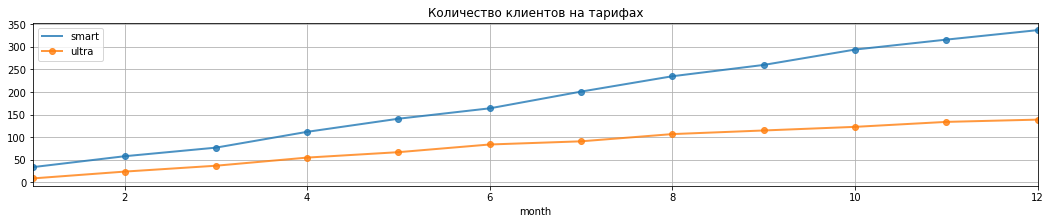

In [34]:
valu = 'user_id'
fun = 'count'
nams = 'Количество клиентов на тарифах'
show_line_gr_tarif(fun, valu, nams)

Графики показывают, что клиентов на тарифе "smart", вероятнее всего это связано с разностью базовых тарифов:
Разница между стоимостями тарифа 1400 рублей;
Разница в количестве трафика 15 ГБ
Разница минут - 2500 минут
Разница сообщений 950 штук. Посмотрим средние показатели.

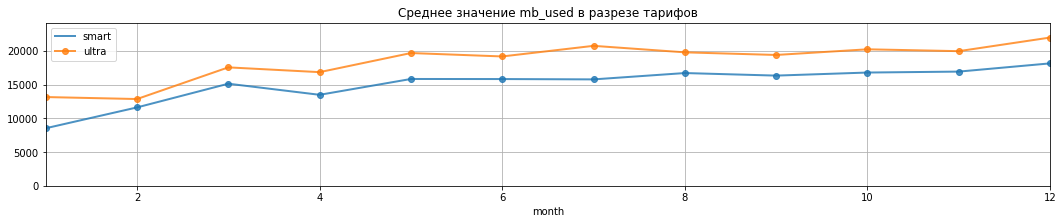

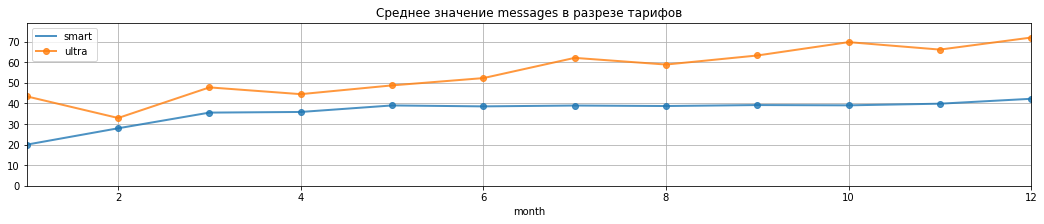

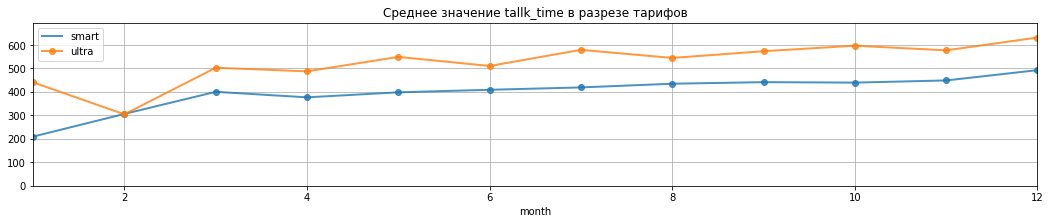

In [35]:
query_smart_mean = (datasets
                    .query('tariff == "smart"')
                    .pivot_table(index = ['year', 'month']
                                 , values = ['messages','tallk_time','mb_used']
                                 , aggfunc = 'mean'
                                )
                    .reset_index()
                   )
query_ultra_mean = (datasets
                    .query('tariff == "ultra"')
                    .pivot_table(index = ['year', 'month']
                                 , values = ['messages','tallk_time','mb_used']
                                 , aggfunc = 'mean')
                    .reset_index()
                   )
column_list_mean = ['mb_used','messages', 'tallk_time']
for i in column_list_mean:
    max_y_means_stat = max((query_smart_mean[i].max()
                            +
                            query_smart_mean[i].max() * 0.1)
                            , (query_ultra_mean[i].max()
                               + 
                               query_ultra_mean[i].max() * 0.1)
                           )
    gr2 = query_smart_mean.plot(
        x='month', # столбец значений для горизонтальной оси
        y= i, # столбец значений для вертикальной оси
        style='o-', # стиль заполнения:'o'(точечный) или 'o-'(точечно-линейный)
        xlim=(1, 12) # границы по оси X
        , linewidth=2
        , alpha=0.8
        , label='smart'
        )    
    query_ultra_mean.plot(
        x='month', # столбец значений для горизонтальной оси
        y= i, # столбец значений для вертикальной оси
        style='o-', # стиль заполнения:'o'(точечный) или 'o-'(точечно-линейный)
        xlim=(1, 12), # границы по оси X
        ylim=(0, max_y_means_stat) # границы по оси Y
        , linewidth=2
        , alpha=0.8
        , label='ultra'
        , ax=gr2
        , figsize=(18, 3) # размеры картинки: (x_size, y_size)
        , grid=True
        , title = 'Среднее значение {} в разрезе тарифов'.format(i))
    plt.show()

На основе динмамик средних показателей можно сделать вывод, что клиенты на тарифе "ultra" используют услуги оператора активнее, вероятнее всего это связано с самими тарифами:
Тариф "smart"
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
Тариф "ultra"
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей
Стоит отметить, что в среднем клиенты тарифа "smart" чаще превышают пороговое значение в 15ГБ трафика.

In [77]:
ultra = datasets[datasets['tariff']=='ultra']
ultra = ultra[['mb_used','messages','tallk_time']]
ultra.describe()

,mb_used,messages,tallk_time
count,975.000000,795.000000,951.000000
mean,19688.587692,61.161006,560.113565
std,9952.830482,45.931026,314.742170
min,1.000000,1.000000,1.000000
25%,12022.000000,24.000000,318.000000
50%,19416.000000,51.000000,544.000000
75%,26921.500000,87.500000,776.500000
max,49793.000000,224.000000,1727.000000


In [78]:
smart = datasets[datasets['tariff']=='smart']
smart = smart[['mb_used','messages','tallk_time']]
smart.describe()

,mb_used,messages,tallk_time
count,2228.000000,1922.000000,2223.000000
mean,16244.472172,38.716441,430.609987
std,5871.037024,26.787949,193.850373
min,1.000000,1.000000,1.000000
25%,12673.250000,17.000000,292.000000
50%,16541.500000,34.000000,435.000000
75%,20078.750000,55.000000,561.000000
max,38627.000000,143.000000,1471.000000


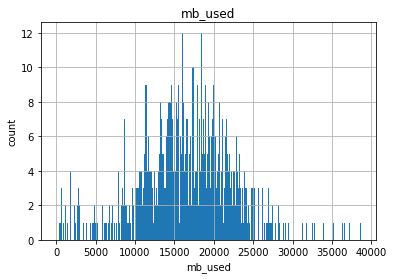

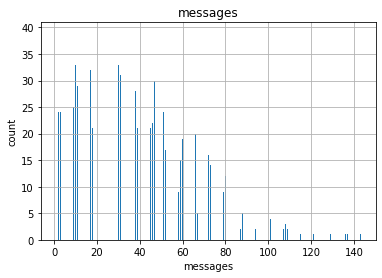

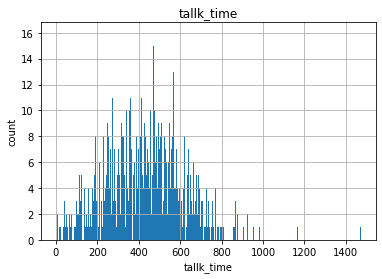

In [47]:
for row in smart:
    plt.show()
    
    smart.hist(row , bins = 1000)
    plt.xlabel(row)
    plt.ylabel('count')

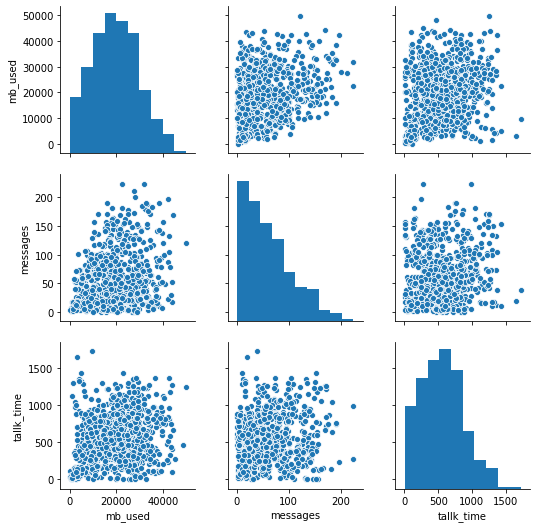

In [54]:
sns.pairplot(ultra);

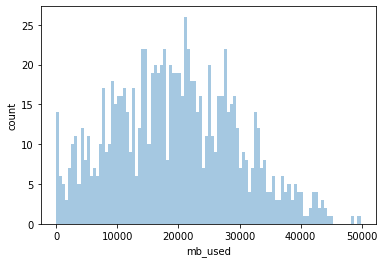

In [86]:
ultra = ultra.fillna(0)
gid = sns.distplot(ultra['mb_used'], kde=False, bins=100);
plt.ylabel('count')
plt.show(gid)

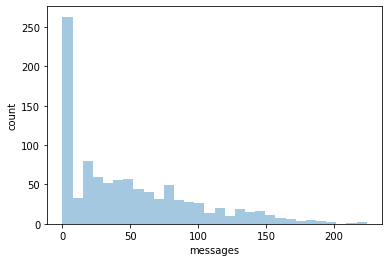

In [83]:
fig = sns.distplot(ultra['messages'], kde=False, bins=30)
plt.ylabel('count')
plt.show(fig)

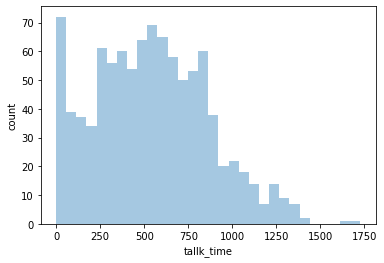

In [84]:
gar = sns.distplot(ultra['tallk_time'], kde=False, bins=30)
plt.ylabel('count')
plt.show(gar)

# Шаг 4

In [106]:
sample_1 = datasets.query('tariff == "ultra"')['revenue'].tolist()
sample_2 = datasets.query('tariff == "smart"')['revenue'].tolist()
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
alpha = 0.05
print('cреднее ultra: ',int(pd.Series(sample_1).mean()))
print('cреднее smart: ',int(pd.Series(sample_2).mean()))
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее ultra:  2071
cреднее smart:  1312
p-значение:  1.2496710269965528e-233
Отвергаем нулевую гипотезу


In [107]:
sample_1 = datasets.query('city == "Москва"')['revenue'].tolist()
sample_2 = datasets.query('city != "Москва"')['revenue'].tolist()
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
alpha = 0.05
print('cреднее ultra: ',int(pd.Series(sample_1).mean()))
print('cреднее smart: ',int(pd.Series(sample_2).mean()))
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  

cреднее ultra:  1561
cреднее smart:  1541
p-значение:  0.5602596027403448
Не получилось отвергнуть нулевую гипотезу


Для формулирования нулевой гипотезы, определил, средний чек тарифа ultra, равный 2071 рублям, а smart — 1312 руб. Значима ли разница между этими числами? С одной стороны значим, ведь есть разница в цифрах, с другой стороны количество клиентов на тарифах тоже разное.
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применил метод scipy.stats.ttest_ind
Аналоничным образом сравнили выборки средней выручки пользователей из Москвы и других регионов.

Вывод общий:
Цель, понять, в рекламу какого тарифа нужно вкладываться. 
В данных есть нулевые мегобайты и звонки, в данном случае согласно правилам тарифа («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.) значения были округлены до 1.
На основании полученных данных было выявлено, что наибольшую прибыль приносит тариф "smart". Данный тариф, за счет своей ценовой политики базового пакета более популярен 78% пользователей выбрали его. Ценовой разрыв между ними составляет 1400р, при этом разрыв по использованию интернет трафика (самая востребованная услуга) - 15 ГБ. 58% дохода этого тарифа составляют дополнительные продажи.
С точки зрения средней выручки с одного пользователя лидерскую позицию оставляет за собой тариф "ultra". Данный тариф приобретают пользователи, которые больше используют телефонную связь и текстовые сообщения.
Стоить отметить, что в среднем на тарифе "smart" пользователи потребляют 16 ГБ трафика, этот показатель на 1 ГБ больше чем предусмотрено тарифом. Данный параметр очень хорошо подобран, т.к. он позволяет дополнительно зарабатывать оператору и не сильно обременяет пользователей. В свою очередь средняя единица данного показателя на тарифе "ultra" составляет 20 ГБ, тарифом предусмотрено 30, в связи с этим дополнительные продажи крайне редки.
Исходя из цели задачи логично продвигать в массу тариф "ultra", так как средняя выручка на пользователя тут больше и более постоянна.